In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .master("local") \
    .appName("NaiveBayes") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumn("winPlaceClass", col("winPlaceClass") -1)
data = data.withColumnRenamed('winPlaceClass', 'label')
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('label', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDistance_SU

In [3]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
inputCols = list(set(inputCols) - set(toRemove))

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

## Feature Selection (correlation) 

In [5]:
pearsonCorr = Correlation.corr(output, 'features', 'pearson').collect()[0][0]
pearsonCorr

DenseMatrix(51, 51, [1.0, 0.1528, 0.2224, 0.2105, 0.333, -0.0649, 0.2009, 0.4154, ..., 0.0282, 0.0175, 0.1055, 0.6199, 0.4667, 0.3734, -0.3697, 1.0], False)

In [6]:
corr_matrix = pd.DataFrame(pearsonCorr.toArray(), inputCols, inputCols)
corr_matrix

,rideDistance_SUM,killStreaks_MAX,assist_SUM,assist_MAX,weaponsAcquired_MAX,isFirstPerson,kills_SUM,heals_SUM,heals_MAX,vehicleDestroys_MAX,...,teamKills_SUM,distance_MAX,headshotKills_AVG,swimDistance_AVG,teamKills_MAX,revives_AVG,weaponsAcquired_SUM,matchtype,maxPlace,revives_MAX
rideDistance_SUM,1.000000,0.152762,0.222432,0.210458,0.332984,-0.064930,0.200857,0.415415,0.356081,0.198282,...,0.097877,0.789482,0.018556,0.040486,0.092545,0.101594,0.399086,0.204986,-0.198033,0.228534
killStreaks_MAX,0.152762,1.000000,0.437395,0.458014,0.340088,0.007442,0.742224,0.368229,0.352522,0.093838,...,0.066021,0.276195,0.276280,0.026650,0.069321,0.181865,0.415764,0.316161,-0.323517,0.364128
assist_SUM,0.222432,0.437395,1.000000,0.926435,0.302686,-0.009378,0.676438,0.434344,0.348942,0.146421,...,0.054404,0.287347,0.100145,0.019821,0.053652,0.224569,0.472382,0.345876,-0.325626,0.445985
assist_MAX,0.210458,0.458014,0.926435,1.000000,0.306735,-0.007986,0.641300,0.415324,0.349849,0.133324,...,0.055919,0.288979,0.105514,0.021752,0.055733,0.224874,0.454030,0.343027,-0.340582,0.433407
weaponsAcquired_MAX,0.332984,0.340088,0.302686,0.306735,1.000000,-0.056457,0.384814,0.399182,0.392444,0.114530,...,0.073458,0.545382,0.131736,0.080258,0.072497,0.146669,0.762004,0.262762,-0.267301,0.302433
isFirstPerson,-0.064930,0.007442,-0.009378,-0.007986,-0.056457,1.000000,-0.003012,-0.013397,-0.014350,-0.034717,...,-0.027972,-0.070804,0.005453,-0.016339,-0.028361,0.002299,-0.047435,-0.017192,0.019070,0.003094
kills_SUM,0.200857,0.742224,0.676438,0.641300,0.384814,-0.003012,1.000000,0.495564,0.441651,0.141999,...,0.055745,0.351444,0.395726,0.031854,0.057148,0.259783,0.494578,0.323815,-0.307399,0.471148
heals_SUM,0.415415,0.368229,0.434344,0.415324,0.399182,-0.013397,0.495564,1.000000,0.929366,0.138561,...,0.100058,0.486093,0.093955,0.070174,0.094602,0.311227,0.507021,0.313793,-0.296815,0.518881
heals_MAX,0.356081,0.352522,0.348942,0.349849,0.392444,-0.014350,0.441651,0.929366,1.000000,0.117984,...,0.082788,0.481331,0.132158,0.078969,0.080214,0.281476,0.425775,0.249298,-0.244853,0.443046
vehicleDestroys_MAX,0.198282,0.093838,0.146421,0.133324,0.114530,-0.034717,0.141999,0.138561,0.117984,1.000000,...,0.131599,0.180920,0.028885,0.011543,0.132891,0.052277,0.144992,0.080085,-0.074648,0.099497


In [7]:
# Seleziono il triangolo superiore della correlation matrix
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Cerco le features con correlazione > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [8]:
to_drop

['assist_MAX',
 'heals_MAX',
 'rideDistance_MAX',
 'heals_AVG',
 'damageDealt_SUM',
 'headshotKills_MAX',
 'rideDistance_AVG',
 'kills_AVG',
 'walkDistance_MAX',
 'roadKills_MAX',
 'damageDealt_MAX',
 'swimDistance_SUM',
 'kills_MAX',
 'DBNOs_MAX',
 'distance_MAX',
 'swimDistance_AVG',
 'teamKills_MAX',
 'matchtype',
 'maxPlace',
 'revives_MAX']

In [9]:
naiveBayesFeat = [col for col in inputCols if col not in to_drop]
naiveBayesFeat

['rideDistance_SUM',
 'killStreaks_MAX',
 'assist_SUM',
 'weaponsAcquired_MAX',
 'isFirstPerson',
 'kills_SUM',
 'heals_SUM',
 'vehicleDestroys_MAX',
 'DBNOs_AVG',
 'revives_SUM',
 'headshotKills_SUM',
 'teamKills_AVG',
 'roadKills_AVG',
 'distance_AVG',
 'hasDisconnected',
 'roadKills_SUM',
 'numGroups',
 'damageDealt_AVG',
 'matchDuration',
 'swimDistance_MAX',
 'walkDistance_SUM',
 'walkDistance_AVG',
 'assist_AVG',
 'weaponsAcquired_AVG',
 'DBNOs_SUM',
 'distance_SUM',
 'longestKill_MAX',
 'teamKills_SUM',
 'headshotKills_AVG',
 'revives_AVG',
 'weaponsAcquired_SUM']

In [10]:
assembler = VectorAssembler(
    inputCols=naiveBayesFeat,
    outputCol="features")

output = assembler.transform(data)

In [11]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.5, seed).select("features", "label")

(training,testing) = output.randomSplit([0.7,0.3], seed=42)
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 706291
testing: 302236


In [12]:
training.groupBy('label').count().toPandas()

,label,count
0,1,165330
1,3,174326
2,5,16619
3,4,168000
4,2,165522
5,0,16494


## Grid Search

paramGrid = ParamGridBuilder() .addGrid(nb.smoothing, [0.0, 1.0, 5.0])  \
    .addGrid(nb.modelType, ['multinomial', 'gaussian']) \
    .build()

In [13]:
nb = NaiveBayes()

paramGrid = ParamGridBuilder() .addGrid(nb.smoothing, [0.0, 0.001, 0.01, 1.0])  \
    .addGrid(nb.modelType, ['multinomial', 'gaussian']) \
    .build()

crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 

cvModel = crossval.fit(training)

In [14]:
# Best parameters
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='NaiveBayes_81fdf52c1ab4', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 0.0, Param(parent='NaiveBayes_81fdf52c1ab4', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'gaussian'}


-------------------------

Individuati i parametri, si fa training sull'intero dataset

In [11]:
assembler = VectorAssembler(
    inputCols=naiveBayesFeat,
    outputCol="features")

output = assembler.transform(data)

(training,testing) = output.select("features", "label").randomSplit([0.7,0.3], seed=42)
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 1410431
testing: 603659


In [12]:
nb = NaiveBayes(modelType='gaussian', smoothing=0.0)
model = nb.fit(training)

In [13]:
predictions = model.transform(testing)

## Evaluation

In [14]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

In [15]:
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0 ,2.0, 3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.3408182434122575
Precision = 0.41683578113255093
F1 measure = 0.36064730652017074
Accuracy = 0.3408182434122576
Class 0.0 precision = 0.24460535011349596
Class 0.0 recall = 0.5976131976131976
Class 0.0 F1 Measure = 0.347129342684717
Class 1.0 precision = 0.6204738125653234
Class 1.0 recall = 0.3790177843041279
Class 1.0 F1 Measure = 0.47058046389550684
Class 2.0 precision = 0.3995485929072216
Class 2.0 recall = 0.31852539263121354
Class 2.0 F1 Measure = 0.35446590461174615
Class 3.0 precision = 0.3446113977127313
Class 3.0 recall = 0.28685795443126166
Class 3.0 F1 Measure = 0.3130936451181258
Class 4.0 precision = 0.3573456206031184
Class 4.0 recall = 0.3019285048873069
Class 4.0 F1 Measure = 0.3273079430395249
Class 5.0 precision = 0.10113244548749808
Class 5.0 recall = 0.8878148592393988
Class 5.0 F1 Measure = 0.1815807322106296
Confusion Matrix
[[8.5130e+03 4.7910e+03 7.5000e+02 1.0300e+02 5.0000e+00 8.3000e+01]
 [1.9767e+04 5.3429e+04 4.9259e+04 1.7746e+04 7.0000e+02 6.6

------------------------

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.60      0.35     14245
           1       0.62      0.38      0.47    140967
           2       0.40      0.32      0.35    141163
           3       0.34      0.29      0.31    149269
           4       0.36      0.30      0.33    143842
           5       0.10      0.89      0.18     14173

    accuracy                           0.34    603659
   macro avg       0.34      0.46      0.33    603659
weighted avg       0.42      0.34      0.36    603659



In [19]:
print(confusion_matrix(y_true, y_pred))

[[ 8513  4791   750   103     5    83]
 [19767 53429 49259 17746   700    66]
 [ 5347 22226 44964 52580 14756  1290]
 [ 1027  5088 15475 42819 61360 23500]
 [  127   566  2056 10764 43430 86899]
 [   22    10    33   241  1284 12583]]


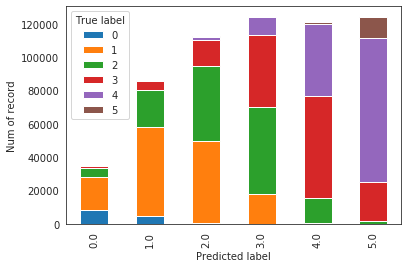

In [28]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
sns.set_style('white')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")
plt.show()

In [29]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    #return fig

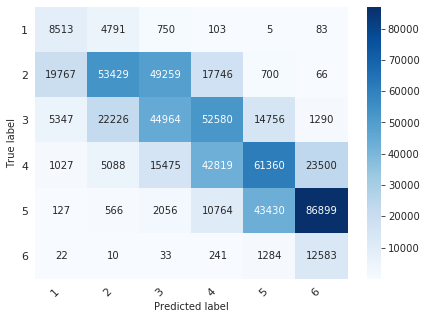

In [31]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names=['1','2','3','4','5','6'],figsize = (7,5), fontsize=11)

In [32]:
spark.stop()